<a href="https://colab.research.google.com/github/liorhirsch/Kaggle-Landmark-ML-Challange/blob/master/our_custom_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload data from google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Build training data


In [0]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from joblib import Parallel, delayed
import multiprocessing


**Upload to memory all the photos.**

The data will be array of arrays. Each sub-array represents one landmark and will contain tuples of landmark photo and landmark id.

In [10]:
DATADIR = "drive/My Drive/photos/"
CATEGORIES =  os.listdir(DATADIR);
print('Found %d categories in : %s' % (len(CATEGORIES), DATADIR))
training_data = []
IMG_SIZE = 100
   
def create_training_data(category):
    data = []
    print("Building training data for landmark id %s" %category);
    path = os.path.join(DATADIR, category)  # path tolandmark photos
    landmark_id = category
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append([new_array, landmark_id])
        except Exception as e:
            pass   # do nothing
    return data;
          
num_cores = multiprocessing.cpu_count();
print('building the training data on %d cores' % num_cores)
training_data_nested=Parallel(n_jobs=num_cores)(delayed(create_training_data)(category) for category in CATEGORIES)

Found 100 categories in : drive/My Drive/photos/
building the training data on 2 cores


KeyboardInterrupt: ignored

**Augmentated Data Generation**

Creates images generators both for the test and the training data, to create additional data

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
train_datagen=ImageDataGenerator(
                              rotation_range=0,
                              width_shift_range=0,
                               height_shift_range=0,
                               shear_range=0,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies


 Uses the data as a stream object to enable batching on it instead of loading them all together to the ram using the ImageDataGenerator

In [27]:
image_size = (100,100)
batch_size = 10

training_data_dir = 'drive/My Drive/photos'
validation_data_dir = 'drive/My Drive/test'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 75315 images belonging to 100 classes.
Found 18780 images belonging to 100 classes.


In [28]:
x_batch, y_batch = next(train_generator)
print(x_batch)
print(y_batch)

[[[[130. 191. 255.]
   [131. 190. 255.]
   [130. 191. 255.]
   ...
   [ 91. 121. 193.]
   [ 32.  50. 122.]
   [ 83. 104. 154.]]

  [[130. 191. 255.]
   [133. 191. 255.]
   [131. 191. 255.]
   ...
   [ 49.  73. 148.]
   [ 37.  61. 131.]
   [101. 127. 175.]]

  [[131. 191. 255.]
   [133. 193. 255.]
   [133. 194. 255.]
   ...
   [ 37.  56. 137.]
   [ 64.  95. 157.]
   [ 56.  71. 145.]]

  ...

  [[218. 220. 209.]
   [ 73.  70.  79.]
   [ 22.  10.  40.]
   ...
   [214. 215. 218.]
   [208. 209. 212.]
   [190. 191. 194.]]

  [[161. 161. 163.]
   [ 98.  95. 104.]
   [ 13.   8.  28.]
   ...
   [200. 202. 205.]
   [203. 205. 208.]
   [191. 191. 194.]]

  [[122. 122. 127.]
   [ 89.  89.  95.]
   [ 20.  20.  31.]
   ...
   [190. 191. 196.]
   [190. 191. 196.]
   [203. 205. 209.]]]


 [[[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]]

  [[255. 255. 255.]
   [255. 255. 255.]
   [255. 255. 255.]
   ...
   [255. 255. 255.]
 

TypeError: ignored

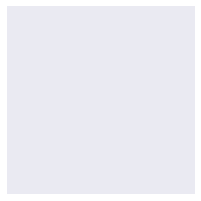

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(type(ctypes.c_float))
    plt.imshow(image)

**FlatMap the data.**

After this proccess, there will be a list of tuples. each tuple contain image and id of single landmark.

In [0]:
training_data_with_real_ids=[landmark_id_pair for landmark_photos in training_data_nested for landmark_id_pair in landmark_photos]

**Create new ids for each landmark id**

Keras can only work when the last layer of nuerons has the max value of the data id.
So, if there is a landmark id that its value is 20000 than, the last layer must have at least 20000 neurons.
In order to make the last layer with 100 neurons, we should generate new id for each landmark from 0 to 99.


In [0]:
all_keys = [id for image, id in training_data_with_real_ids];
unique_keys = set(all_keys);
ids_dictionary = {};


for idx, curr_id in enumerate(unique_keys):
  ids_dictionary[curr_id] = idx
  

In [0]:
print(ids_dictionary['11249'])

51


**Assign new id to each landmark in the training data.**

In [0]:
training_data = [ [image, ids_dictionary[id] ] for image, id in training_data_with_real_ids]

In [0]:
import random

random.shuffle(training_data)

Build the training data as expected to keras library.




In [0]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(int(label))

# We need to convert the List of images to a numpy array for Tensorflow
# We create a numpy array where the image is in the shape of (50,50,1). 1 since this is a gray scale
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
print(X[0].shape)

(100, 100, 1)


# Train

In [0]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv3D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

**Normalize the images.**

In [0]:
X = X/255.0


In [0]:
model = Sequential()
model.add(Conv2D(64, (3,3), input_shape = X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

#Flatening the data
model.add(Flatten())
model.add(Dense(150))
model.add(Activation("relu"))

#output layer
model.add(Dense(100))
model.add(Activation('softmax'))

In [0]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        640       
_________________________________________________________________
activation (Activation)      (None, 98, 98, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 47, 47, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
__________

In [0]:
adamOptimizer = tf.keras.optimizers.Adam(lr=0.001)

model.compile(loss = 'sparse_categorical_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

# model.compile(loss='categorical_crossentropy', optimizer='adam',\
#  metrics=['accuracy'])

In [0]:

model.fit(X, y, batch_size=32, epochs = 30, validation_split=0.1)

# model.fit(X, y, batch_size=64, epochs=1, verbose=1, \
# validation_split=0.2, shuffle=True)

Train on 9049 samples, validate on 1006 samples
Epoch 1/30
9049/9049 [==============================] - 10s 1ms/step - loss: 1.2049 - acc: 0.7001 - val_loss: 4.9783 - val_acc: 0.1660
Epoch 2/30
9049/9049 [==============================] - 10s 1ms/step - loss: 0.3762 - acc: 0.9125 - val_loss: 6.1722 - val_acc: 0.1700
Epoch 3/30
9049/9049 [==============================] - 10s 1ms/step - loss: 0.1261 - acc: 0.9752 - val_loss: 7.1375 - val_acc: 0.1670
Epoch 4/30
9049/9049 [==============================] - 10s 1ms/step - loss: 0.0503 - acc: 0.9939 - val_loss: 7.6738 - val_acc: 0.1640
Epoch 5/30
9049/9049 [==============================] - 10s 1ms/step - loss: 0.0445 - acc: 0.9938 - val_loss: 8.0054 - val_acc: 0.1581
Epoch 6/30
9049/9049 [==============================] - 10s 1ms/step - loss: 0.0554 - acc: 0.9896 - val_loss: 7.9130 - val_acc: 0.1521
Epoch 7/30
9049/9049 [==============================] - 10s 1ms/step - loss: 0.1148 - acc: 0.9708 - val_loss: 7.8337 - val_acc: 0.1521
Epoch 8

In [0]:
train_loss, train_acc = model.evaluate(X,y)


10055/10055 [==============================] - 4s 390us/step


In [0]:
print(train_loss)
print(train_acc)

0.9807335368920803
0.9118846345190857
